# **Assignment 1: Core Transformer Components from Scratch**  
**Objective**: Implement the mathematical backbone of transformers.  

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math

In [2]:
# par défaut sur les GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

False

In [3]:
def getPE(seq_len, d, n = 1e4):
    PE = torch.zeros((seq_len,d), dtype=torch.float32, device="cpu")
    denom = n
    for i in range(seq_len):
        for k in torch.arange(int(d/2)):
            PE[i,2*k] = torch.sin(i/(denom**(2*k/d)))
            PE[i,2*k+1] = torch.cos(i/(denom**(2*k/d)))
    return PE

## 1. **Positional Encoding**:  
   - Code the sinusoidal positional encoding matrix using only `torch.tensor` operations (no `nn.Module`).  
   - Prove mathematically why the dot product of positional embeddings encodes relative distances.  
   - Visualize the positional encoding matrix heatmap for sequence lengths 0–100.  

### Theory

1. **Séquence d'entrée**
Séquence de longueur L, contenant des tokens sous forme de vecteurs d'embedding de dimension d.

$$X \in \mathbb R ^{L \times d}$$

où L est la longueur de la séquence et d est la dimension des embeddings.  
   - **Note**: Utilisez `torch` pour les calculs, mais évitez les modules de haut niveau comme `nn.Embedding`.

2. **Position Encoding (PE)**
On ajoute un vecteur $PE_i$ à chaque embedding $X_i$ pour avoir une représentation enrichie. Au final la matrice devient:

$$X' = X + PE$$


3. **Formule de calcul du Positional Encoding (sinusoïdal) :**  
   L'approche la plus courante utilise des fonctions sinusoïdales de différentes fréquences :
   $$
   PE_{(i, 2k)} = \sin\left(\frac{i}{10000^{\frac{2k}{d}}}\right)
   $$
   $$
   PE_{(i, 2k+1)} = \cos\left(\frac{i}{10000^{\frac{2k}{d}}}\right)
   $$
   où :
   - $i$ est l’index du token dans la séquence (position).
   - $k$ est l’index de la dimension dans l’espace d’embedding.
   - $d$ est la dimension totale de l’embedding.

4. **Interprétation :**  
   - Les fréquences différentes permettent de capturer des relations entre tokens à différentes échelles.
   - Ces fonctions permettent d’encoder les positions tout en préservant des propriétés qui facilitent l’apprentissage, notamment en permettant au modèle d’interpréter les positions relatives de manière fluide.


### Coding the positional encoding

In [4]:
d = 512 # embeddings
seq_len = 100 # mots

In [5]:
PE = getPE(4,6)
print(PE)

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000],
        [ 0.9093, -0.4161,  0.0927,  0.9957,  0.0043,  1.0000],
        [ 0.1411, -0.9900,  0.1388,  0.9903,  0.0065,  1.0000]])


In [6]:
# plot PE
import matplotlib.pyplot as plt

PE = getPE(1000,100, n = 1e4)

[]

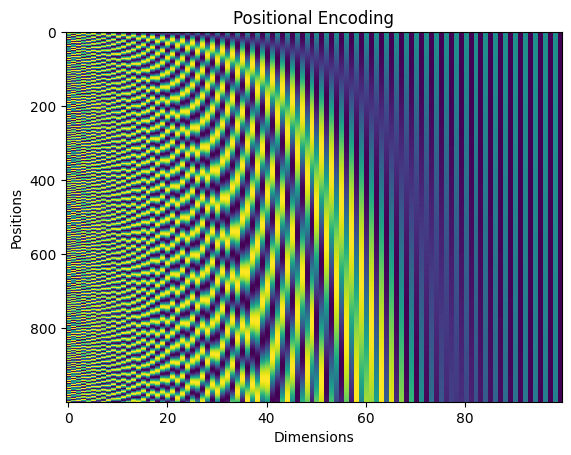

In [7]:
ax = plt.subplot(111)
plt.title("Positional Encoding")
plt.xlabel("Dimensions")
plt.ylabel("Positions")

cax = ax.imshow(PE, cmap='viridis_r', interpolation='none', aspect='auto')
# plt.gcf().colorbar(cax)
plt.plot()

### Démo + Contexte

#### **1. Contexte : du Positional Encoding à l'Attention**  

On rappelle les étapes :  

1. **On ajoute le positional encoding** à l'embedding initial :  
   $$
   X' = X + PE
   $$  

2. **On calcule les matrices Query, Key et Value :**  
   $$
   Q = X' W_Q, \quad K = X' W_K, \quad V = X' W_V
   $$  

3. **On calcule l'Attention Score :**  
   $$
   \text{Attention} = \text{softmax} \left( \frac{Q K^T}{\sqrt{d_k}} \right) V
   $$  

Ainsi, le cœur du mécanisme repose sur **le produit scalaire $Q K^T$**.  

---

#### **2. Pourquoi se pose la question du produit scalaire $PE^T PE$ ?**  

Si on explicite $Q$ et $K$ en remplaçant $X' = X + PE$ :  

$$
Q = (X + PE) W_Q, \quad K = (X + PE) W_K
$$

Le score d'attention devient :  

$$
Q K^T = (X + PE) W_Q W_K^T (X + PE)^T
$$

Développons ce terme :  

$$
Q K^T = X W_Q W_K^T X^T + X W_Q W_K^T PE^T + PE W_Q W_K^T X^T + PE W_Q W_K^T PE^T
$$

Le dernier terme **$PE W_Q W_K^T PE^T$** est particulièrement intéressant. Si $W_Q W_K^T$ est bien conditionné, ce terme est **proportionnel à** :  

$$
PE PE^T
$$

Donc, pour comprendre comment l'Attention encode les distances relatives, il faut comprendre la structure du **produit scalaire entre positional encodings**. **D'où la demande de démontrer que $\langle PE(i) ,  PE(j) \rangle$ encode la distance relative $|i - j|$.**  

---

#### **3.Preuve**

Montrons que pour deux positions $i,j \in \{1,2,..d\}$,
$$
\langle PE(i) ,  PE(j) \rangle \propto |i-j|
$$

---

1. **Structure du Positional Encoding**

On utilise :  
$$
PE_{(i, 2k)} = \sin\left(\frac{i}{10000^{\frac{2k}{d}}}\right), \quad PE_{(i, 2k+1)} = \cos\left(\frac{i}{10000^{\frac{2k}{d}}}\right)
$$
pour deux positions $i$ et $j$.


2. **Expression du Produit Scalaire**

Le produit scalaire entre $PE(i)$ et $PE(j)$ est :
$$
PE(i) \cdot PE(j) = \sum_{k=0}^{d/2 - 1} \left[ \sin\left(\frac{i}{\lambda_k}\right) \sin\left(\frac{j}{\lambda_k}\right) + \cos\left(\frac{i}{\lambda_k}\right) \cos\left(\frac{j}{\lambda_k}\right) \right]
$$
où $\lambda_k = 10000^{\frac{2k}{d}}$.

Grâce à l'identité trigonométrique :
$$
\cos(A - B) = \cos A \cos B + \sin A \sin B
$$
on obtient :
$$
PE(i) \cdot PE(j) = \sum_{k=0}^{d/2 - 1} \cos\left(\frac{i - j}{\lambda_k}\right)
$$



3. **Conclusion**

Le produit scalaire entre $PE(i)$ et $PE(j)$ **ne dépend que de la différence $i - j$**, ce qui montre que les positional encodings **encodent les distances relatives**.
T



## 2. Self-Attention

   - Implement scaled dot-product attention **without** using `torch.nn.MultiheadAttention`:  
     - Compute $Q$, $K$, $V$ matrices manually ($W_Q$, $W_K$, $W_V$ as learnable parameters).  
     - Derive the gradient of the attention weights $\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)$ w.r.t. $Q$ and $K$ (symbolic math).  
   - Compare your implementation’s output to PyTorch’s `F.scaled_dot_product_attention` (tolerance < 1e-6).  

### Dimensionnement des matrices

Bonne question ! Définissons **précisément** les dimensions des matrices pour bien comprendre ce qui se passe.

---

#### **1. Dimensions de $X$ et $PE$**
On suppose :  
- Une séquence de **longueur** $L$ (nombre de tokens).
- Une **dimension d’embedding** $d$ (chaque mot est un vecteur de taille $d$).  

Les matrices sont donc :  
$$
X \in \mathbb{R}^{L \times d}, \quad PE \in \mathbb{R}^{L \times d}
$$

Comme $X' = X + PE$, on a toujours $X' \in \mathbb{R}^{L \times d}$.

---

#### **2. Dimensions des matrices $Q, K, V$**
On veut que chaque token ait un vecteur Query, Key et Value de taille $d_k$ (en général $d_k = d/ h$ avec $h$ le nombre de têtes d'attention, mais restons généraux).  

On applique des transformations linéaires :  

$$
Q = X' W_Q, \quad K = X' W_K, \quad V = X' W_V
$$

avec  
$$
W_Q \in \mathbb{R}^{d \times d_k}, \quad W_K \in \mathbb{R}^{d \times d_k}, \quad W_V \in \mathbb{R}^{d \times d_v}
$$

Ce qui donne :  
$$
Q \in \mathbb{R}^{L \times d_k}, \quad K \in \mathbb{R}^{L \times d_k}, \quad V \in \mathbb{R}^{L \times d_v}
$$

> **Remarque** : Souvent, $d_k = d_v = d_h$ et dans un **multi-head attention**, on a plusieurs têtes de taille $d_k = d/h$, mais ici on considère une seule tête.

---

#### **3. Dimension de $Q K^T$**
L'Attention se base sur le produit scalaire entre **Query et Key** :  

$$
Q K^T \in \mathbb{R}^{L \times d_k} \times \mathbb{R}^{d_k \times L} = \mathbb{R}^{L \times L}
$$

Ce qui est logique : **on obtient une matrice qui encode la similarité entre chaque paire de tokens dans la séquence.**  

### Coding: Self-attention

In [5]:
h = 1 # number of attention heads
d_k = int(d/h)

NameError: name 'd' is not defined

In [6]:
torch.manual_seed(1)
X = torch.rand((seq_len, d))
X = X + getPE(seq_len, d)
W_Q = torch.rand((d, d_k))
W_K = torch.rand((d, d_k))
W_V = torch.rand((d, d_k))

NameError: name 'seq_len' is not defined

In [7]:
Q = X @ W_Q
K = X @ W_K
V = X @ W_V

NameError: name 'X' is not defined

In [9]:
def attention(Q,K,V):
    d_k_func = torch.tensor(Q.shape[1])
    return F.softmax(Q@K.T/torch.sqrt(d_k_func)) @ V

In [10]:
# compare with torch

torch.allclose(attention(Q,K,V), F.scaled_dot_product_attention(Q,K,V), atol=1e-6)

/tmp/ipykernel_17699/2115172868.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(Q@K.T/torch.sqrt(d_k_func)) @ V


True

In [11]:
attention(Q,K,V).shape, F.scaled_dot_product_attention(Q,K,V).shape

/tmp/ipykernel_17699/2115172868.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(Q@K.T/torch.sqrt(d_k_func)) @ V


(torch.Size([100, 512]), torch.Size([100, 512]))

[]

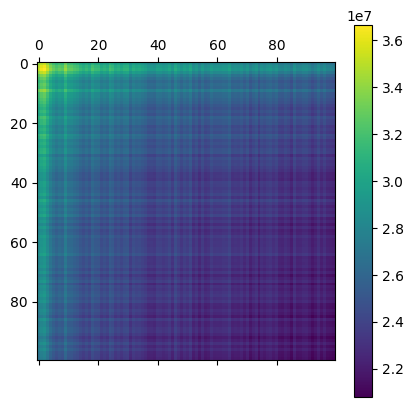

In [12]:
cax2 = plt.matshow(Q@K.T, cmap='viridis')
plt.gcf().colorbar(cax2)
plt.plot()

In [4]:
# Making it a class

class MultiheadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.0):
        super(MultiheadAttention, self).__init__()

        self.embed_dim = embed_dim  # Total dimension of the model.
        self.num_heads = num_heads  # Number of parallel attention heads.
        self.head_dim = embed_dim // num_heads # embed_dim will split across num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"

        # Create projection matrices as learnable parameters
        self.q_proj = nn.Linear(embed_dim, embed_dim, bias=False) # vstack des W^Q_i
        self.k_proj = nn.Linear(embed_dim, embed_dim, bias=False) # vstack des W^K_i
        self.v_proj = nn.Linear(embed_dim, embed_dim, bias=False) # vstack des W^V_i
        self.out_proj = nn.Linear(embed_dim, embed_dim, bias=False) # W_O

        # Compute scaling factor once and for all
        self.scale_factor = 1 / math.sqrt(self.head_dim)

        # initialize dropouts
        self.dropout = nn.Dropout(p=dropout)


    def forward(self, query, key, value, attn_mask=None):
        # shape (batch_size, seq_len, embed_dim) 
        batch_size = query.size(0)

        # Project and reshape to (batch_size, heads, seq_len, head_dim)
        q = self.q_proj(query).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1,2)  # Apply W_Q to query
        k = self.k_proj(key).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1,2)    # Apply W_K to key
        v = self.v_proj(value).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1,2)  # ApplyW_V to value

        # Scale dot-product attention: (batch, heads, seq_len, head_dim) @ (batch, heads, head_dim, seq_len)
        attn_weights = q @ k.transpose(-2, -1) * self.scale_factor

        # Apply mask if provided
        if attn_mask is not None:
            # Expand mask for batch and heads dimensions
            if attn_mask.dim() == 2:  # (seq_len, seq_len)
                attn_mask = attn_mask.unsqueeze(0).unsqueeze(0)
            attn_weights = attn_weights.masked_fill(attn_mask == 0, float('-inf'))
    

        # Apply softmax
        attn_weights = F.softmax(attn_weights, dim=-1)

        # apply droupout to attention weights
        attn_weights = self.dropout(attn_weights)

        # Apply attention weights: (batch, heads, seq_len, seq_len) @ (batch, heads, seq_len, head_dim)
        attn_output = attn_weights @ v

        # Reshape back: (batch, heads, seq_len, head_dim) -> (batch, seq_len, embed_dim)
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.embed_dim)

        # project to output dimension (using W_O)
        attn_output = self.out_proj(attn_output) 

        # apply dropout to attetion_weights
        attn_output = self.dropout(attn_output)

        return attn_output, attn_weights


#### **Pourquoi appliquer self.out_proj sur attn_output ?**

`attn_output` est déjà de la bonne dimension (batch, seq_len, embed_dim) avant d'appliquer `self.out_proj`. Alors pourquoi cette projection de sortie est-elle nécessaire?

**Le rôle essentiel de self.out_proj**

Cette projection finale (parfois appelée W_O dans la littérature) sert plusieurs fonctions cruciales:

1. **Mélange des informations des différentes têtes**:
   - Avant `self.out_proj`, les informations des différentes têtes sont simplement concaténées
   - Sans projection, ces informations resteraient cloisonnées par tête
   - `self.out_proj` apprend à combiner de façon optimale les représentations des différentes têtes

2. **Transformation linéaire apprise**:
   - Ce n'est pas une simple identité, mais une transformation qui a des paramètres apprenables
   - Elle permet au modèle d'ajuster l'importance relative des contributions de chaque tête

3. **Stabilité de l'apprentissage**:
   - Elle aide à stabiliser les gradients qui arrivent des couches supérieures
   - Sans elle, ces gradients seraient directement propagés vers chaque tête sans intégration

**Analogie**

Imaginons que chaque tête d'attention est un expert spécialisé qui fournit son analyse:
- La transformation `self.out_proj` est comme un "chef d'équipe" qui intègre les analyses de tous les experts
- Sans cette étape, vous auriez h opinions d'experts indépendantes, sans cohérence globale




#### Test de MultiheadAttention

In [5]:
d = 512
MA = MultiheadAttention(embed_dim=d, num_heads=8)

In [6]:
seq_len = 12
X = torch.rand((1, seq_len, d))
X = X + getPE(seq_len, d)
_, attn_weights = MA(X, X, X)

In [7]:
# head = 3
# cax = plt.matshow(attn_weights[0,head].detach().numpy(), cmap='viridis')
# plt.gcf().colorbar(cax2)
# plt.plot()

##### Creating an intercatvie Attention head Visualization with bokeh/HoloViews

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
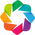

In [8]:
import numpy as np
import holoviews as hv
from holoviews import opts
import panel as pn
hv.extension('bokeh')

def plot_attention_heads(attn_weights):
    """
    Create an interactive plot to visualize different attention heads
    
    Parameters:
    attn_weights: Tensor of shape (batch, num_heads, seq_len, seq_len)
    """
    # Convert to numpy and get dimensions
    attn_weights_np = attn_weights.detach().cpu().numpy()
    batch_size, num_heads, seq_len, _ = attn_weights_np.shape
    
    # Create a function that returns the heatmap for a given head index
    def get_attention_heatmap(head_idx):
        # Get data for the specified head
        data = attn_weights_np[0, head_idx]
        
        # Create the heatmap
        heatmap = hv.HeatMap((np.arange(seq_len), np.arange(seq_len), data))
        
        # Style the heatmap
        heatmap = heatmap.opts(
            opts.HeatMap(
                cmap='viridis',
                colorbar=True,
                width=400,
                height=400,
                tools=['hover'],
                title=f'Attention Head {head_idx}',
                xlabel='Token Position (Key)',
                ylabel='Token Position (Query)'
            )
        )
        return heatmap
    
    # Create a dynamic map with a range slider for head selection
    dmap = hv.DynamicMap(get_attention_heatmap, kdims=[hv.Dimension('head', range=(0, num_heads-1), step=1)])
    
    # Set up the layout with a slider
    return dmap

In [9]:
plot_attention_heads(attn_weights)

BokehModel(combine_events=True, render_bundle={'docs_json': {'3e0b87d1-b0e6-427d-817e-853c2f5900fc': {'version…

## 3. Feed-Foward-Network

In [18]:
class FeedForwardBlock(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.0):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.linear2(self.dropout(F.relu(self.linear1(x))))

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, features):
        self.alpha = nn.Parameter(torch.ones(features)) # both learnable parameters
        self.bias = nn.Parameter(torch.zeros(features))

    def forward(self, x):
        # x : (batch_size, seq_len, hidden_size)
        mean = x.mean(dim)

# Part 2. Full transformer architecture

## Masked Self-Attention

In [11]:
# masked attention
attn_mask  = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()
# attn_mask = attn_mask.to(device)

_, attn_weights = MA(X, X, X, attn_mask=attn_mask)

plot_attention_heads(attn_weights)

BokehModel(combine_events=True, render_bundle={'docs_json': {'07e4833f-def5-4c6a-b63d-bcd4a1e7b7cb': {'version…

## Embedding layer

In [12]:
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
text = "3+5=8"
encoded_input = tokenizer(text, return_tensors='pt')

In [13]:
encoded_input['input_ids'].shape

torch.Size([1, 5])

In [14]:
# Create embedding layer

embedding_dim = 512
vocab_size = tokenizer.vocab_size

# Create the embedding layer
token_embedding = nn.Embedding(vocab_size, embedding_dim)

# Initialize the embedding layer
nn.init.xavier_uniform_(token_embedding.weight)

Parameter containing:
tensor([[-0.0106, -0.0049,  0.0021,  ...,  0.0105,  0.0025, -0.0011],
        [-0.0011,  0.0104, -0.0098,  ..., -0.0049, -0.0038, -0.0049],
        [-0.0006, -0.0071, -0.0084,  ..., -0.0081,  0.0018, -0.0053],
        ...,
        [ 0.0019, -0.0061,  0.0101,  ...,  0.0003,  0.0008, -0.0053],
        [ 0.0102,  0.0033,  0.0041,  ..., -0.0029, -0.0104, -0.0019],
        [-0.0051, -0.0090,  0.0006,  ..., -0.0051, -0.0085,  0.0050]],
       requires_grad=True)

In [15]:
def get_embeddings(encoded_input):
    """
    Convert token IDs to embeddings
    
    Args:
        encoded_input: Dictionary from tokenizer or tensor of token IDs
        
    Returns:
        Tensor of shape [batch_size, sequence_length, embedding_dim]
    """
    input_ids = encoded_input['input_ids']
    
    # Ensure input_ids is a tensor
    if not isinstance(input_ids, torch.Tensor):
        input_ids = torch.tensor(input_ids)
    
    # Get embeddings
    embeddings = token_embedding(input_ids)
    
    return embeddings

# Example usage
text = "3+3=6"
encoded_input = tokenizer(text, return_tensors="pt")
input_embeddings = get_embeddings(encoded_input)

print(f"Input shape: {encoded_input['input_ids'].shape}")
print(f"Embedding shape: {input_embeddings.shape}")

Input shape: torch.Size([1, 5])
Embedding shape: torch.Size([1, 5, 512])


In [16]:
def get_complete_embeddings(encoded_input):
    """Get token embeddings with positional encodings"""
    # Get token embeddings
    token_embeddings = get_embeddings(encoded_input)
    
    # Get sequence length
    seq_length = token_embeddings.shape[1]
    
    # Get positional encodings
    pos_encodings = getPE(seq_length, embedding_dim)
    
    # Add positional encodings to token embeddings
    return token_embeddings + pos_encodings

In [17]:
complete_embeddings = get_complete_embeddings(encoded_input)
print(f"Complete embedding shape: {complete_embeddings.shape}")


Complete embedding shape: torch.Size([1, 5, 512])


## Encoder

In [ ]:
class Encoderblock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attention = MultiheadAttention(embed_dim, num_heads, dropout)
        self.ff = FeedForward